# Generate Datasets

In [1]:
import torch
from tqdm import tqdm
import numpy as np
from stable_baselines3 import DQN
import warnings
import pandas as pd
import gc  # Import garbage collector module

warnings.filterwarnings("ignore")

In [2]:
SEED = 12345
ENV_ID = 'SeaquestNoFrameskip-v4'
EPOCHS = 10
TRIALS = 5

In [3]:
# ensure the module is re-imported after changes
import importlib

import datasets.dataset_utils
importlib.reload(datasets.dataset_utils)

from datasets.dataset_utils import set_all_seeds
from datasets.dataset_utils import create_environment
from datasets.dataset_utils import check_dataset
from datasets.dataset_utils import save_dataset
from datasets.dataset_utils import load_dataset
from datasets.dataset_utils import preprocess_and_split
from datasets.dataset_utils import create_dataloaders
from datasets.dataset_utils import inspect_dataset_sample
from datasets.dataset_utils import analyze_action_distribution

In [4]:
# ensure the module is re-imported after changes
import importlib

import behavioral_cloning_bc.bc_utils
importlib.reload(behavioral_cloning_bc.bc_utils)

from behavioral_cloning_bc.bc_utils import train_and_evaluate_BC

In [5]:
# set seed for reproducability
set_all_seeds(SEED)

# force PyTorch to use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [6]:
# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

# Expert

In [ ]:
# Define the DQN hyperparameters
dqn_params = {
    'learning_rate': 0.0001,
    'buffer_size': 10000,
    'learning_starts': 100000,
    'batch_size': 32,
    'train_freq': 4,
    'gradient_steps': 1,
    'target_update_interval': 1000,
    'exploration_fraction': 0.1,
    'exploration_initial_eps': 1.0,
    'exploration_final_eps': 0.01,
    'device': device,
    'seed': SEED,
    'verbose': 1,
}

# Initialize the DQN agent
dqn_agent = DQN('CnnPolicy', env, **dqn_params)

# Train the agent
dqn_agent.learn(total_timesteps=5_000_000)

# Save the trained model
dqn_agent.save("dqn_seaquest_expert_agent(5mio)")

# took 416min 42s to train

In [7]:
# load the agent (self trained agent, for 5M steps)
dqn_agent_loaded = DQN.load("dqn_seaquest_expert_agent(5mio)", device=device, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


continue training the agent

In [7]:
# Re-create the environment
env = create_environment(env_id=ENV_ID, seed=SEED)

# Load the saved model
dqn_agent = DQN.load("dqn_seaquest_expert_agent(5mio)", env=env, device=device)

# Continue training the agent
additional_timesteps = 5_000_000  # Train for an additional 5 million timesteps
dqn_agent.learn(total_timesteps=additional_timesteps)

# Save the updated model
dqn_agent.save("dqn_seaquest_expert_agent(10mio)")

# took 375min 15s to train

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.76e+03 |
|    ep_rew_mean      | 90       |
|    exploration_rate | 0.978    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 4236     |
|    time_elapsed     | 2        |
|    total_timesteps  | 11045    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.91e+03 |
|    ep_rew_mean      | 95       |
|    exploration_rate | 0.954    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4448     |
|    time_elapsed     | 5        |
|    total_timesteps  | 23297    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.85e+03 |
|    ep

In [7]:
def evaluate_dqn_agent(env, model, num_episodes=10):
    episode_rewards = []
    action_counts = {}
    # use tqdm
    for episode in tqdm(range(num_episodes)):
        obs, info = env.reset()
        done = False
        total_rewards = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)

            # Convert action to scalar if it's a NumPy array
            if isinstance(action, np.ndarray):
                action = action.item()
                
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_rewards += reward
            # Log action
            action_counts[action] = action_counts.get(action, 0) + 1
            
        episode_rewards.append(total_rewards)
        print(f"Episode {episode + 1}: Total Reward = {total_rewards}")
    average_reward = np.mean(episode_rewards)
    print(f"Average Reward over {num_episodes} episodes: {average_reward}")
    print(f"Action Counts: {action_counts}")
    return average_reward, action_counts

# Evaluate the trained DQN agent
average_reward, action_counts = evaluate_dqn_agent(env, dqn_agent_loaded)

 10%|█         | 1/10 [00:09<01:24,  9.33s/it]

Episode 1: Total Reward = 660.0


 20%|██        | 2/10 [00:15<00:57,  7.21s/it]

Episode 2: Total Reward = 660.0


 30%|███       | 3/10 [00:20<00:46,  6.59s/it]

Episode 3: Total Reward = 660.0


 40%|████      | 4/10 [00:27<00:38,  6.40s/it]

Episode 4: Total Reward = 660.0


 50%|█████     | 5/10 [00:32<00:31,  6.24s/it]

Episode 5: Total Reward = 660.0


 60%|██████    | 6/10 [00:38<00:24,  6.14s/it]

Episode 6: Total Reward = 660.0


 70%|███████   | 7/10 [00:44<00:18,  6.07s/it]

Episode 7: Total Reward = 660.0


 80%|████████  | 8/10 [00:50<00:12,  6.03s/it]

Episode 8: Total Reward = 660.0


 90%|█████████ | 9/10 [00:56<00:05,  5.99s/it]

Episode 9: Total Reward = 660.0


100%|██████████| 10/10 [01:02<00:00,  6.26s/it]

Episode 10: Total Reward = 660.0
Average Reward over 10 episodes: 660.0
Action Counts: {16: 2317, 7: 1290, 9: 3460, 12: 2100, 15: 5400, 6: 3180, 14: 680, 17: 1000, 8: 4370, 13: 3610, 2: 830, 0: 1990, 10: 1010, 1: 2070, 11: 700, 3: 5550, 5: 210, 4: 1610}


## expert dataset

In [8]:
# ensure the module is re-imported after changes
import datasets.expert.expert_dataset
importlib.reload(datasets.expert.expert_dataset)

from datasets.expert.expert_dataset import generate_expert_dataset_seaquest

### 0%

In [8]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

expert_datasets_save_path = 'datasets/expert/expert_logs'
file_name = 'expert_dataset_perturbation_0.pkl'

# without perturbation
expert_dataset_perturbation_0 = generate_expert_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=15, 
  perturbation=False, 
  save_path=expert_datasets_save_path, 
  file_name=file_name
)

Generating Expert Dataset for Seaquest...


Generating dataset: 100%|██████████| 15/15 [09:58<00:00, 39.87s/it]


Length of expert dataset: 62065
Number of perturbed steps: 0
Dataset saved to datasets/expert/expert_logs\expert_dataset_perturbation_0.pkl


Check Dataset Action Distribution

In [10]:
# Analyze the dataset
action_distribution = analyze_action_distribution(expert_dataset_perturbation_0)

Action distribution in expert dataset: {0: 2985, 1: 3105, 2: 1245, 3: 8325, 4: 2415, 5: 315, 6: 4770, 7: 1935, 8: 6555, 9: 5190, 10: 1515, 11: 1050, 12: 3150, 13: 5415, 14: 1020, 15: 8100, 16: 3475, 17: 1500}


In [ ]:
# free up memory
del expert_dataset_perturbation_0

### 5%

In [8]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

expert_datasets_save_path = 'datasets/expert/expert_logs'
file_name = 'expert_dataset_perturbation_5.pkl'

# without perturbation
expert_dataset_perturbation_5 = generate_expert_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=17, 
  perturbation=True, 
  perturbation_level=0.05,
  save_path=expert_datasets_save_path, 
  file_name=file_name
)

Generating Expert Dataset for Seaquest...


Generating dataset: 100%|██████████| 17/17 [11:17<00:00, 39.85s/it]


Length of expert dataset: 64827
Number of perturbed steps: 3306
Dataset saved to datasets/expert/expert_logs\expert_dataset_perturbation_5.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(expert_dataset_perturbation_5)

Action distribution in expert dataset: {0: 1980, 1: 2497, 2: 1765, 3: 5157, 4: 2331, 5: 631, 6: 5512, 7: 2365, 8: 6210, 9: 5925, 10: 2057, 11: 951, 12: 3546, 13: 7006, 14: 1803, 15: 9266, 16: 3114, 17: 2711}


In [ ]:
# free up memory
del expert_dataset_perturbation_5

### 10%

In [8]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

expert_datasets_save_path = 'datasets/expert/expert_logs'
file_name = 'expert_dataset_perturbation_10.pkl'

# without perturbation
expert_dataset_perturbation_10 = generate_expert_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=14, 
  perturbation=True, 
  perturbation_level=0.1,
  save_path=expert_datasets_save_path, 
  file_name=file_name
)

Generating Expert Dataset for Seaquest...


Generating dataset: 100%|██████████| 14/14 [12:03<00:00, 51.67s/it]


Length of expert dataset: 65127
Number of perturbed steps: 6609
Dataset saved to datasets/expert/expert_logs\expert_dataset_perturbation_10.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(expert_dataset_perturbation_10)

Action distribution in expert dataset: {0: 1564, 1: 1962, 2: 1408, 3: 6206, 4: 2197, 5: 716, 6: 5985, 7: 2132, 8: 6381, 9: 5545, 10: 2284, 11: 1236, 12: 3553, 13: 7071, 14: 2545, 15: 8591, 16: 3074, 17: 2677}


In [ ]:
# free up memory
del expert_dataset_perturbation_10

### 20%

In [9]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

expert_datasets_save_path = 'datasets/expert/expert_logs'
file_name = 'expert_dataset_perturbation_20.pkl'

# without perturbation
expert_dataset_perturbation_20 = generate_expert_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=19, 
  perturbation=True, 
  perturbation_level=0.2,
  save_path=expert_datasets_save_path, 
  file_name=file_name
)

Generating Expert Dataset for Seaquest...


Generating dataset: 100%|██████████| 19/19 [09:42<00:00, 30.66s/it]


Length of expert dataset: 64470
Number of perturbed steps: 13076
Dataset saved to datasets/expert/expert_logs\expert_dataset_perturbation_20.pkl


Check Dataset Action Distribution

In [10]:
# Analyze the dataset
action_distribution = analyze_action_distribution(expert_dataset_perturbation_20)

Action distribution in expert dataset: {0: 2103, 1: 2339, 2: 2017, 3: 5089, 4: 2834, 5: 1031, 6: 5312, 7: 2321, 8: 5882, 9: 5823, 10: 2218, 11: 1149, 12: 3478, 13: 6400, 14: 2022, 15: 8456, 16: 3391, 17: 2605}


In [ ]:
# free up memory
del expert_dataset_perturbation_20

In [8]:
# load both datasets
expert_loaded_perturbation_0 = load_dataset('Expert_dataset_Perturbation_0.pkl')
expert_loaded_perturbation_20 = load_dataset('Expert_dataset_Perturbation_20.pkl')

## mixed dataset

In [7]:
# ensure the module is re-imported after changes
import datasets.mixed.mixed_dataset
importlib.reload(datasets.mixed.mixed_dataset)

from datasets.mixed.mixed_dataset import generate_mixed_dataset_seaquest

### 0%

In [11]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

mixed_datasets_save_path = 'datasets/mixed/mixed_logs'
file_name = 'mixed_dataset_perturbation_0.pkl'

# without perturbation
mixed_dataset_perturbation_0 = generate_mixed_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=23, 
  perturbation=False, 
  mix_ratio=0.5, 
  save_path=mixed_datasets_save_path, 
  file_name=file_name
  )

Generating Mixed Dataset for Seaquest...


Generating dataset: 100%|██████████| 23/23 [05:00<00:00, 13.06s/it]


Length of mixed dataset: 64718
Number of perturbed steps: 0
Dataset saved to datasets/mixed/mixed_logs\mixed_dataset_perturbation_0.pkl


Check Dataset Action Distribution

In [12]:
# Analyze the dataset
action_distribution = analyze_action_distribution(mixed_dataset_perturbation_0)

Action distribution in expert dataset: {0: 2655, 1: 2873, 2: 2819, 3: 3798, 4: 3445, 5: 1875, 6: 4418, 7: 2994, 8: 5386, 9: 5887, 10: 3087, 11: 1942, 12: 2755, 13: 5180, 14: 2357, 15: 6829, 16: 3359, 17: 3059}


In [13]:
# free up memory
del mixed_dataset_perturbation_0

### 5%

In [12]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

mixed_datasets_save_path = 'datasets/mixed/mixed_logs'
file_name = 'mixed_dataset_perturbation_5.pkl'

# with perturbation
mixed_dataset_perturbation_5 = generate_mixed_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=23, 
  perturbation=True, 
  perturbation_level=0.05, 
  mix_ratio=0.5, 
  save_path=mixed_datasets_save_path, 
  file_name=file_name
  )

Generating Mixed Dataset for Seaquest...


Generating dataset: 100%|██████████| 23/23 [05:02<00:00, 13.17s/it]


Length of mixed dataset: 62026
Number of perturbed steps: 3143
Dataset saved to datasets/mixed/mixed_logs\mixed_dataset_perturbation_5.pkl


Check Dataset Action Distribution

In [13]:
# Analyze the dataset
action_distribution = analyze_action_distribution(mixed_dataset_perturbation_5)

Action distribution in expert dataset: {0: 2659, 1: 2656, 2: 2709, 3: 3354, 4: 3436, 5: 1873, 6: 3870, 7: 2743, 8: 5410, 9: 5417, 10: 3051, 11: 1851, 12: 2896, 13: 4950, 14: 2222, 15: 6712, 16: 3191, 17: 3026}


In [14]:
# free up memory
del mixed_dataset_perturbation_5

### 10%

In [17]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

mixed_datasets_save_path = 'datasets/mixed/mixed_logs'
file_name = 'mixed_dataset_perturbation_10.pkl'

# with perturbation
mixed_dataset_perturbation_10 = generate_mixed_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=23, 
  perturbation=True, 
  perturbation_level=0.1, 
  mix_ratio=0.5, 
  save_path=mixed_datasets_save_path, 
  file_name=file_name
  )

Generating Mixed Dataset for Seaquest...


Generating dataset: 100%|██████████| 23/23 [02:44<00:00,  7.14s/it]


Length of mixed dataset: 64250
Number of perturbed steps: 6506
Dataset saved to datasets/mixed/mixed_logs\mixed_dataset_perturbation_10.pkl


Analyze Dataset Action Distribution

In [18]:
# Analyze the dataset
action_distribution = analyze_action_distribution(mixed_dataset_perturbation_10)

Action distribution in expert dataset: {0: 2645, 1: 2871, 2: 2893, 3: 3841, 4: 3475, 5: 2052, 6: 3804, 7: 3086, 8: 5366, 9: 5661, 10: 2941, 11: 2071, 12: 3026, 13: 5010, 14: 2316, 15: 6515, 16: 3421, 17: 3256}


In [19]:
# free up memory
del mixed_dataset_perturbation_10

### 20%

In [20]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

mixed_datasets_save_path = 'datasets/mixed/mixed_logs'
file_name = 'mixed_dataset_perturbation_20.pkl'

# with perturbation
mixed_dataset_perturbation_20 = generate_mixed_dataset_seaquest(
  env, 
  dqn_agent_loaded, 
  num_episodes=23, 
  perturbation=True, 
  perturbation_level=0.2, 
  mix_ratio=0.5, 
  save_path=mixed_datasets_save_path, 
  file_name=file_name
  )

Generating Mixed Dataset for Seaquest...


Generating dataset: 100%|██████████| 23/23 [04:07<00:00, 10.74s/it]


Length of mixed dataset: 65830
Number of perturbed steps: 13364
Dataset saved to datasets/mixed/mixed_logs\mixed_dataset_perturbation_20.pkl


Analyze Dataset Action Distribution

In [21]:
# Analyze the dataset
action_distribution = analyze_action_distribution(mixed_dataset_perturbation_20)

Action distribution in expert dataset: {0: 2834, 1: 2969, 2: 2973, 3: 3852, 4: 3507, 5: 2248, 6: 4131, 7: 3120, 8: 5579, 9: 5345, 10: 3220, 11: 2294, 12: 2931, 13: 4928, 14: 2592, 15: 6311, 16: 3571, 17: 3425}


In [22]:
# free up memory
del mixed_dataset_perturbation_20

## replay dataset

In [8]:
# ensure the module is re-imported after changes
import datasets.replay.replay_dataset
importlib.reload(datasets.replay.replay_dataset)

from datasets.replay.replay_dataset import generate_replay_dataset_seaquest

In [9]:
# load the models, one with 5M steps and the other with 10M steps
models = [
  DQN.load("dqn_seaquest_expert_agent(5mio)", device=device, env=env), 
  DQN.load("dqn_seaquest_expert_agent(10mio)", device=device, env=env)
  ]

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### 0%

In [8]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

replay_datasets_save_path = 'datasets/replay/replay_logs'
file_name = 'replay_dataset_perturbation_0.pkl'

# without perturbation
replay_dataset_perturbation_0 = generate_replay_dataset_seaquest(
  env, 
  models, 
  num_episodes=15, 
  perturbation=False, 
  save_path=replay_datasets_save_path, 
  file_name=file_name
  )

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Generating Replay Dataset for Seaquest...


Generating dataset: 100%|██████████| 15/15 [03:05<00:00, 12.36s/it]


Length of replay dataset: 64893
Number of perturbed steps: 0
Dataset saved to datasets/replay/replay_logs\replay_dataset_perturbation_0.pkl


Check Dataset Action Distribution

In [9]:
# Analyze the dataset
action_distribution = analyze_action_distribution(replay_dataset_perturbation_0)

Action distribution in expert dataset: {0: 3125, 1: 2174, 2: 3072, 3: 4440, 4: 1652, 5: 588, 6: 3496, 7: 3398, 8: 4476, 9: 4768, 10: 4546, 11: 4984, 12: 3626, 13: 2965, 14: 2728, 15: 6119, 16: 4219, 17: 4517}


In [10]:
# free up memory
del replay_dataset_perturbation_0

### 5%

In [11]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

replay_datasets_save_path = 'datasets/replay/replay_logs'
file_name = 'replay_dataset_perturbation_5.pkl'

# with perturbation
replay_dataset_perturbation_5 = generate_replay_dataset_seaquest(
  env, 
  models, 
  num_episodes=12, 
  perturbation=True, 
  perturbation_level=0.05, 
  save_path=replay_datasets_save_path, 
  file_name=file_name
  )

Generating Replay Dataset for Seaquest...


Generating dataset: 100%|██████████| 12/12 [03:49<00:00, 19.11s/it]


Length of replay dataset: 66285
Number of perturbed steps: 3391
Dataset saved to datasets/replay/replay_logs\replay_dataset_perturbation_5.pkl


Check Dataset Action Distribution

In [12]:
# Analyze the dataset
action_distribution = analyze_action_distribution(replay_dataset_perturbation_5)

Action distribution in expert dataset: {0: 2201, 1: 1826, 2: 2963, 3: 2740, 4: 2102, 5: 943, 6: 3654, 7: 4094, 8: 4106, 9: 4315, 10: 4440, 11: 6670, 12: 2990, 13: 2982, 14: 3901, 15: 5216, 16: 4750, 17: 6392}


In [13]:
# free up memory
del replay_dataset_perturbation_5

### 10%

In [10]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

replay_datasets_save_path = 'datasets/replay/replay_logs'
file_name = 'replay_dataset_perturbation_10.pkl'

# with perturbation
replay_dataset_perturbation_10 = generate_replay_dataset_seaquest(
  env, 
  models, 
  num_episodes=13, 
  perturbation=True, 
  perturbation_level=0.1, 
  save_path=replay_datasets_save_path, 
  file_name=file_name
  )

Generating Replay Dataset for Seaquest...


Generating dataset: 100%|██████████| 13/13 [07:25<00:00, 34.25s/it]


Length of replay dataset: 65858
Number of perturbed steps: 6686
Dataset saved to datasets/replay/replay_logs\replay_dataset_perturbation_10.pkl


Check Dataset Action Distribution

In [11]:
# Analyze the dataset
action_distribution = analyze_action_distribution(replay_dataset_perturbation_10)

Action distribution in expert dataset: {0: 1987, 1: 1760, 2: 3078, 3: 1970, 4: 2243, 5: 1182, 6: 3512, 7: 4684, 8: 3728, 9: 4187, 10: 4691, 11: 7367, 12: 3175, 13: 2407, 14: 3419, 15: 4845, 16: 4753, 17: 6870}


In [12]:
# free up memory
del replay_dataset_perturbation_10

### 20%

In [15]:
# set seed for reproducability
set_all_seeds(SEED)

# initialize enviornment
env = create_environment(env_id=ENV_ID, seed=SEED)

replay_datasets_save_path = 'datasets/replay/replay_logs'
file_name = 'replay_dataset_perturbation_20.pkl'

# with perturbation
replay_dataset_perturbation_20 = generate_replay_dataset_seaquest(
  env, 
  models, 
  num_episodes=14, 
  perturbation=True, 
  perturbation_level=0.2, 
  save_path=replay_datasets_save_path, 
  file_name=file_name
  )

Generating Replay Dataset for Seaquest...


Generating dataset: 100%|██████████| 14/14 [15:22<00:00, 65.92s/it] 


Length of replay dataset: 65407
Number of perturbed steps: 13279
Dataset saved to datasets/replay/replay_logs\replay_dataset_perturbation_20.pkl


Check Dataset Action Distribution

In [16]:
# Analyze the dataset
action_distribution = analyze_action_distribution(replay_dataset_perturbation_20)

Action distribution in expert dataset: {0: 2533, 1: 1813, 2: 3387, 3: 1779, 4: 2838, 5: 1460, 6: 3732, 7: 4462, 8: 3515, 9: 4438, 10: 4253, 11: 7199, 12: 3025, 13: 2304, 14: 4006, 15: 3839, 16: 4049, 17: 6775}


In [17]:
# free up memory
del replay_dataset_perturbation_20

# Expert

## Load datasets and Preprocess them

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/expert/expert_logs/expert_dataset_perturbation_0.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

Loading expert_dataset_perturbation_0 dataset...
Data preprocessing for expert_dataset_perturbation_0 dataset...
Creating dataloaders for expert_dataset_perturbation_0 dataset...


In [8]:
print(dataloaders.keys())

dict_keys(['expert_dataset_perturbation_0'])


In [9]:
# inspect dataset samples
dataset_name_to_inspect = 'expert_dataset_perturbation_0'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting expert_dataset_perturbation_0 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 9
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting expert_dataset_perturbation_0 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type

# BC Expert

In [8]:
print(device)

cuda


Training on expert_dataset_perturbation_0
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [42:56<00:00, 257.67s/it]


Initial learning rate: 0.001000
Finished Training on expert_dataset_perturbation_0 - Training Loss: 0.01089
Finished Tuning on expert_dataset_perturbation_0 - Tuning Loss: 0.04061
Finished Testing on expert_dataset_perturbation_0 - Test Loss: 0.04983
Finished Evaluating on expert_dataset_perturbation_0 - average Reward: 246.00
Loss curves saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_0/loss_curves_0.pkl
Model saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_0/bc_model_0.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [52:36<00:00, 315.69s/it]


Initial learning rate: 0.001000
Finished Training on expert_dataset_perturbation_0 - Training Loss: 0.01707
Finished Tuning on expert_dataset_perturbation_0 - Tuning Loss: 0.01977
Finished Testing on expert_dataset_perturbation_0 - Test Loss: 0.01639
Finished Evaluating on expert_dataset_perturbation_0 - average Reward: 246.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [59:22<00:00, 356.27s/it]


Initial learning rate: 0.001000
Finished Training on expert_dataset_perturbation_0 - Training Loss: 0.01964
Finished Tuning on expert_dataset_perturbation_0 - Tuning Loss: 0.00544
Finished Testing on expert_dataset_perturbation_0 - Test Loss: 0.00536
Finished Evaluating on expert_dataset_perturbation_0 - average Reward: 276.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [55:39<00:00, 333.90s/it]


Initial learning rate: 0.001000
Finished Training on expert_dataset_perturbation_0 - Training Loss: 0.03804
Finished Tuning on expert_dataset_perturbation_0 - Tuning Loss: 0.02057
Finished Testing on expert_dataset_perturbation_0 - Test Loss: 0.01684
Finished Evaluating on expert_dataset_perturbation_0 - average Reward: 236.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [1:04:32<00:00, 387.21s/it]


Initial learning rate: 0.001000
Finished Training on expert_dataset_perturbation_0 - Training Loss: 0.00297
Finished Tuning on expert_dataset_perturbation_0 - Tuning Loss: 0.00133
Finished Testing on expert_dataset_perturbation_0 - Test Loss: 0.00111
Finished Evaluating on expert_dataset_perturbation_0 - average Reward: 254.00



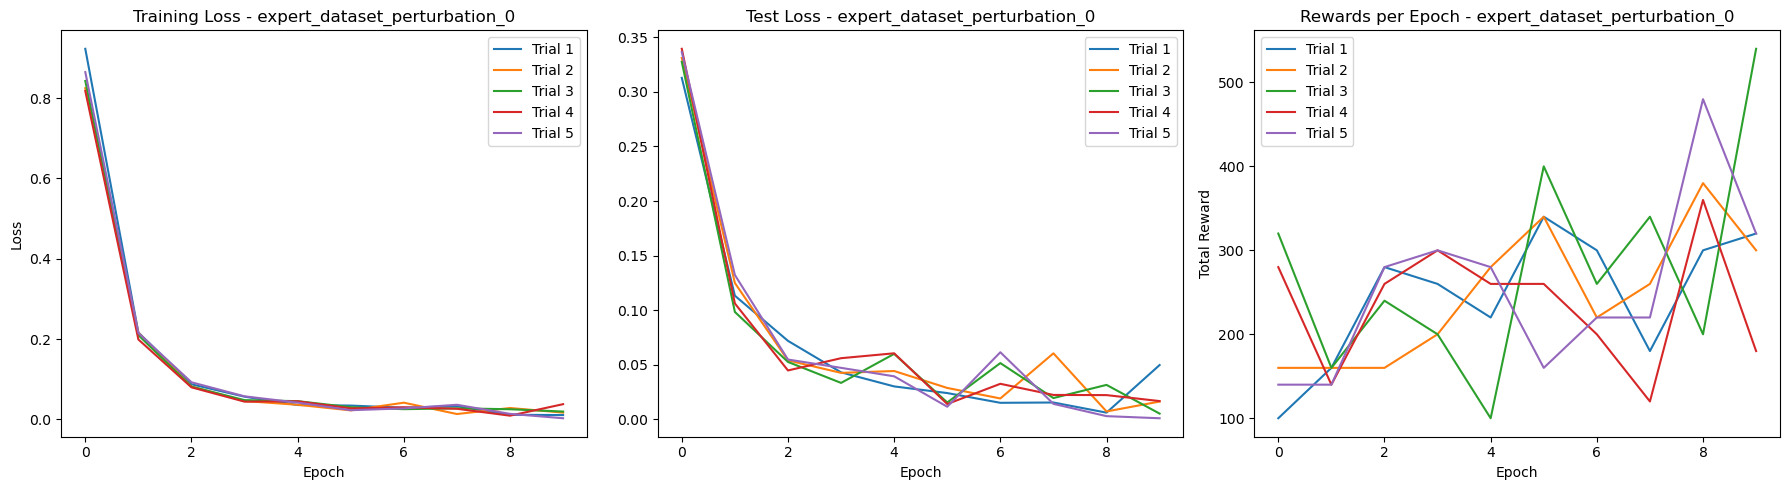

----- Execution time: Random -----
CPU times: total: 25min 58s
Wall time: 4h 35min 14s


In [12]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='expert_dataset_perturbation_0',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Random -----")

In [8]:
# Paths to your datasets
dataset_paths = [
    'datasets/expert/expert_logs/expert_dataset_perturbation_5.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

Loading expert_dataset_perturbation_5 dataset...
Data preprocessing for expert_dataset_perturbation_5 dataset...
Creating dataloaders for expert_dataset_perturbation_5 dataset...


In [9]:
print(dataloaders.keys())

dict_keys(['expert_dataset_perturbation_5'])


In [10]:
# inspect dataset samples
dataset_name_to_inspect = 'expert_dataset_perturbation_5'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting expert_dataset_perturbation_5 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 8
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting expert_dataset_perturbation_5 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type

Training on expert_dataset_perturbation_5
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [46:12<00:00, 277.30s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_5 - Training Loss: 0.26357
Finished Tuning on expert_dataset_perturbation_5 - Tuning Loss: 1.60773
Finished Testing on expert_dataset_perturbation_5 - Test Loss: 1.58283
Finished Evaluating on expert_dataset_perturbation_5 - average Reward: 252.00
Loss curves saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_5/loss_curves_5.pkl
Model saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_5/bc_model_5.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [43:53<00:00, 263.31s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_5 - Training Loss: 0.30961
Finished Tuning on expert_dataset_perturbation_5 - Tuning Loss: 1.52208
Finished Testing on expert_dataset_perturbation_5 - Test Loss: 1.49769
Finished Evaluating on expert_dataset_perturbation_5 - average Reward: 276.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [54:31<00:00, 327.11s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_5 - Training Loss: 0.27107
Finished Tuning on expert_dataset_perturbation_5 - Tuning Loss: 1.58548
Finished Testing on expert_dataset_perturbation_5 - Test Loss: 1.56818
Finished Evaluating on expert_dataset_perturbation_5 - average Reward: 304.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [53:36<00:00, 321.62s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on expert_dataset_perturbation_5 - Training Loss: 0.25105
Finished Tuning on expert_dataset_perturbation_5 - Tuning Loss: 1.60188
Finished Testing on expert_dataset_perturbation_5 - Test Loss: 1.55902
Finished Evaluating on expert_dataset_perturbation_5 - average Reward: 264.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [57:24<00:00, 344.48s/it] 


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_5 - Training Loss: 0.31063
Finished Tuning on expert_dataset_perturbation_5 - Tuning Loss: 1.58249
Finished Testing on expert_dataset_perturbation_5 - Test Loss: 1.55596
Finished Evaluating on expert_dataset_perturbation_5 - average Reward: 230.00



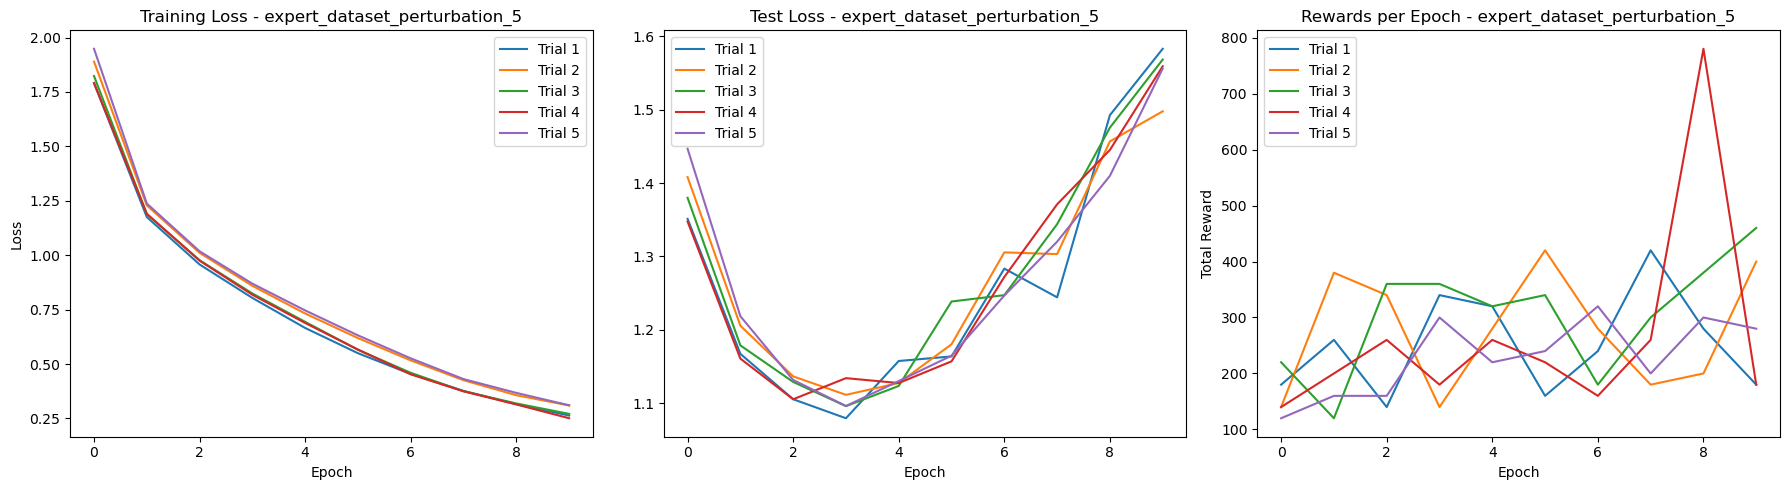

----- Execution time: Random -----
CPU times: total: 23min 36s
Wall time: 4h 15min 44s


In [11]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='expert_dataset_perturbation_5',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Random -----")

In [12]:
# Paths to your datasets
dataset_paths = [
    'datasets/expert/expert_logs/expert_dataset_perturbation_10.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

Loading expert_dataset_perturbation_10 dataset...
Data preprocessing for expert_dataset_perturbation_10 dataset...
Creating dataloaders for expert_dataset_perturbation_10 dataset...


In [13]:
print(dataloaders.keys())

dict_keys(['expert_dataset_perturbation_10'])


In [14]:
# inspect dataset samples
dataset_name_to_inspect = 'expert_dataset_perturbation_10'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting expert_dataset_perturbation_10 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 11
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting expert_dataset_perturbation_10 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data T

Training on expert_dataset_perturbation_10
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [40:10<00:00, 241.04s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on expert_dataset_perturbation_10 - Training Loss: 0.29688
Finished Tuning on expert_dataset_perturbation_10 - Tuning Loss: 2.12021
Finished Testing on expert_dataset_perturbation_10 - Test Loss: 2.16550
Finished Evaluating on expert_dataset_perturbation_10 - average Reward: 252.00
Loss curves saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_10/loss_curves_10.pkl
Model saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_10/bc_model_10.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [57:49<00:00, 347.00s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_10 - Training Loss: 0.35238
Finished Tuning on expert_dataset_perturbation_10 - Tuning Loss: 2.08242
Finished Testing on expert_dataset_perturbation_10 - Test Loss: 2.10765
Finished Evaluating on expert_dataset_perturbation_10 - average Reward: 318.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [56:49<00:00, 340.93s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_10 - Training Loss: 0.35502
Finished Tuning on expert_dataset_perturbation_10 - Tuning Loss: 2.15118
Finished Testing on expert_dataset_perturbation_10 - Test Loss: 2.19265
Finished Evaluating on expert_dataset_perturbation_10 - average Reward: 314.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [1:35:11<00:00, 571.16s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_10 - Training Loss: 0.32906
Finished Tuning on expert_dataset_perturbation_10 - Tuning Loss: 2.13735
Finished Testing on expert_dataset_perturbation_10 - Test Loss: 2.19675
Finished Evaluating on expert_dataset_perturbation_10 - average Reward: 360.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [1:35:00<00:00, 570.03s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_10 - Training Loss: 0.33576
Finished Tuning on expert_dataset_perturbation_10 - Tuning Loss: 2.05321
Finished Testing on expert_dataset_perturbation_10 - Test Loss: 2.11273
Finished Evaluating on expert_dataset_perturbation_10 - average Reward: 254.00



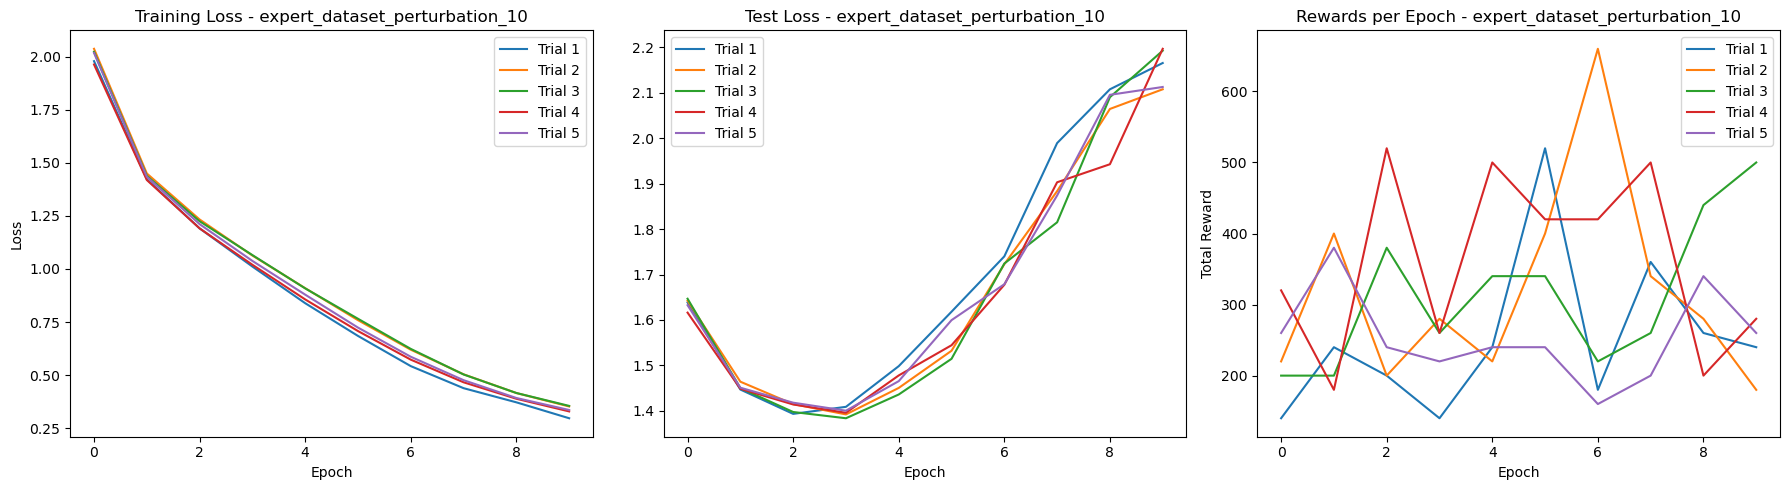

----- Execution time: Random -----
CPU times: total: 21min 35s
Wall time: 5h 45min 5s


In [15]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='expert_dataset_perturbation_10',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Random -----")

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/expert/expert_logs/expert_dataset_perturbation_20.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

Loading expert_dataset_perturbation_20 dataset...
Data preprocessing for expert_dataset_perturbation_20 dataset...
Creating dataloaders for expert_dataset_perturbation_20 dataset...


In [8]:
print(dataloaders.keys())

dict_keys(['expert_dataset_perturbation_20'])


In [9]:
# inspect dataset samples
dataset_name_to_inspect = 'expert_dataset_perturbation_20'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting expert_dataset_perturbation_20 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 6
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting expert_dataset_perturbation_20 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Ty

Training on expert_dataset_perturbation_20
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [42:13<00:00, 253.39s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on expert_dataset_perturbation_20 - Training Loss: 0.50509
Finished Tuning on expert_dataset_perturbation_20 - Tuning Loss: 2.68918
Finished Testing on expert_dataset_perturbation_20 - Test Loss: 2.73762
Finished Evaluating on expert_dataset_perturbation_20 - average Reward: 236.00
Loss curves saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_20/loss_curves_20.pkl
Model saved to behavioral_cloning_bc/bc_logs/expert_dataset/perturbation_20/bc_model_20.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [42:57<00:00, 257.72s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on expert_dataset_perturbation_20 - Training Loss: 0.56875
Finished Tuning on expert_dataset_perturbation_20 - Tuning Loss: 2.71189
Finished Testing on expert_dataset_perturbation_20 - Test Loss: 2.78585
Finished Evaluating on expert_dataset_perturbation_20 - average Reward: 262.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [46:50<00:00, 281.09s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on expert_dataset_perturbation_20 - Training Loss: 0.53269
Finished Tuning on expert_dataset_perturbation_20 - Tuning Loss: 2.73620
Finished Testing on expert_dataset_perturbation_20 - Test Loss: 2.75763
Finished Evaluating on expert_dataset_perturbation_20 - average Reward: 252.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [49:26<00:00, 296.65s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on expert_dataset_perturbation_20 - Training Loss: 0.48583
Finished Tuning on expert_dataset_perturbation_20 - Tuning Loss: 2.69241
Finished Testing on expert_dataset_perturbation_20 - Test Loss: 2.74594
Finished Evaluating on expert_dataset_perturbation_20 - average Reward: 194.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [59:08<00:00, 354.82s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on expert_dataset_perturbation_20 - Training Loss: 0.54677
Finished Tuning on expert_dataset_perturbation_20 - Tuning Loss: 2.63511
Finished Testing on expert_dataset_perturbation_20 - Test Loss: 2.69245
Finished Evaluating on expert_dataset_perturbation_20 - average Reward: 282.00



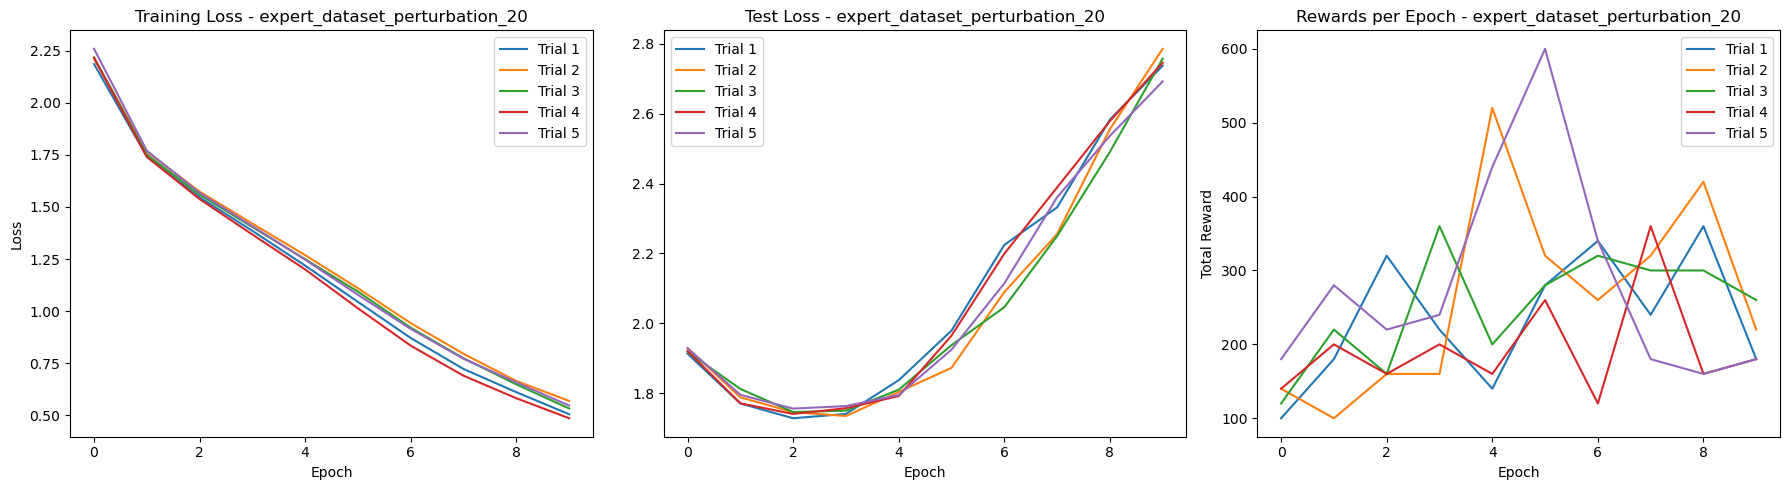

----- Execution time: Random -----
CPU times: total: 23min 7s
Wall time: 4h 40s


: 

In [10]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='expert_dataset_perturbation_20',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Random -----")

TODO: CHECK MODEL SAVING THEN ALL DATASETS GENERATEN UND ALLES LAUFEN LASSEN UND MODEL SAVING TESTEN UND LOSS SAVING AUCH ÄNDERN DASS NUR DATALOADER HEIssT 

In [24]:
action_dim = 18
# Load the saved BC model
bc_model_loaded = BCModel(action_dim, SEED, 0).to(device)
model_save_path = "behavioral_cloning_bc/bc_model_Expert_dataset_Perturbation_0.pth"
bc_model_loaded.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

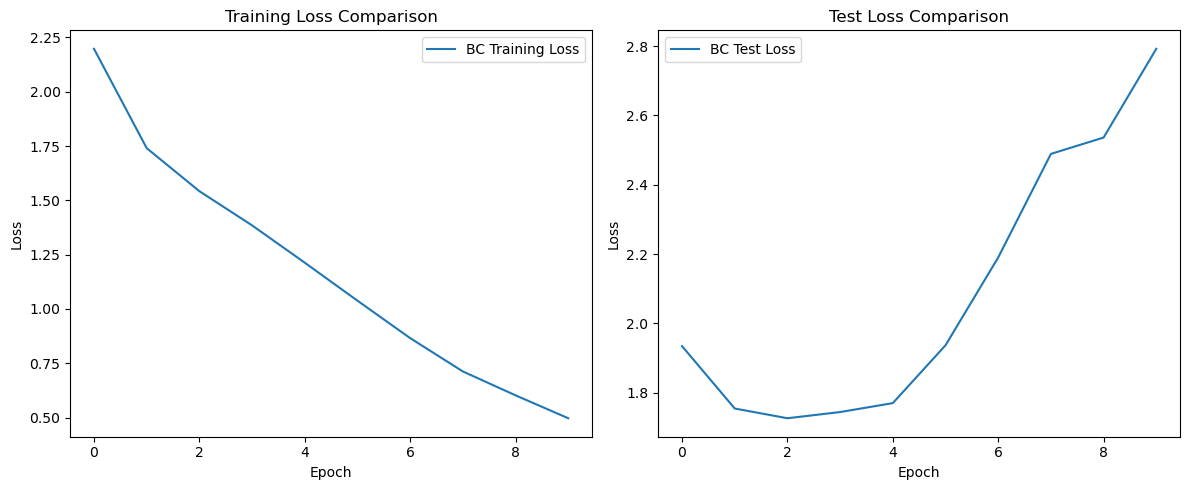

In [10]:
# Load loss curves for BC model
bc_loss_data = load_loss_curves("behavioral_cloning_bc/Expert_dataset_Perturbation_20_loss_curves.pkl")
bc_train_losses = bc_loss_data['train_losses']
bc_test_losses = bc_loss_data['test_losses']
bc_rewards = bc_loss_data['rewards']


# Plot comparison of BC vs IQL
def plot_model_comparison(bc_train, bc_test):#, iql_train, iql_test):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Training loss comparison
    ax[0].plot(bc_train[0], label='BC Training Loss')
    #ax[0].plot(iql_train[0], label='IQL Training Loss')
    ax[0].set_title('Training Loss Comparison')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Test loss comparison
    ax[1].plot(bc_test[0], label='BC Test Loss')
    #ax[1].plot(iql_test[0], label='IQL Test Loss')
    ax[1].set_title('Test Loss Comparison')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function to compare models
plot_model_comparison(bc_train_losses, bc_test_losses)#, iql_train_losses, iql_test_losses)


# Mixed

## Load datasets and Preprocess them

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/mixed/mixed_logs/mixed_dataset_perturbation_0.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

Loading mixed_dataset_perturbation_0 dataset...
Data preprocessing for mixed_dataset_perturbation_0 dataset...
Creating dataloaders for mixed_dataset_perturbation_0 dataset...


In [8]:
print(dataloaders.keys())

dict_keys(['mixed_dataset_perturbation_0'])


In [10]:
# inspect dataset samples
dataset_name_to_inspect = 'mixed_dataset_perturbation_0'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting mixed_dataset_perturbation_0 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 13
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting mixed_dataset_perturbation_0 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type:

Training on mixed_dataset_perturbation_0
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [42:01<00:00, 252.12s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_0 - Training Loss: 0.95229
Finished Tuning on mixed_dataset_perturbation_0 - Tuning Loss: 4.17168
Finished Testing on mixed_dataset_perturbation_0 - Test Loss: 4.17487
Finished Evaluating on mixed_dataset_perturbation_0 - average Reward: 202.00
Loss curves saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_0/loss_curves_0.pkl
Model saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_0/bc_model_0.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [39:15<00:00, 235.57s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_0 - Training Loss: 0.98069
Finished Tuning on mixed_dataset_perturbation_0 - Tuning Loss: 4.03953
Finished Testing on mixed_dataset_perturbation_0 - Test Loss: 3.99986
Finished Evaluating on mixed_dataset_perturbation_0 - average Reward: 186.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [41:44<00:00, 250.50s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_0 - Training Loss: 1.01361
Finished Tuning on mixed_dataset_perturbation_0 - Tuning Loss: 3.98512
Finished Testing on mixed_dataset_perturbation_0 - Test Loss: 3.93940
Finished Evaluating on mixed_dataset_perturbation_0 - average Reward: 200.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [57:21<00:00, 344.15s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_0 - Training Loss: 0.95134
Finished Tuning on mixed_dataset_perturbation_0 - Tuning Loss: 4.11730
Finished Testing on mixed_dataset_perturbation_0 - Test Loss: 4.04424
Finished Evaluating on mixed_dataset_perturbation_0 - average Reward: 234.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [54:59<00:00, 329.98s/it] 


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_0 - Training Loss: 1.08539
Finished Tuning on mixed_dataset_perturbation_0 - Tuning Loss: 3.78820
Finished Testing on mixed_dataset_perturbation_0 - Test Loss: 3.78115
Finished Evaluating on mixed_dataset_perturbation_0 - average Reward: 206.00



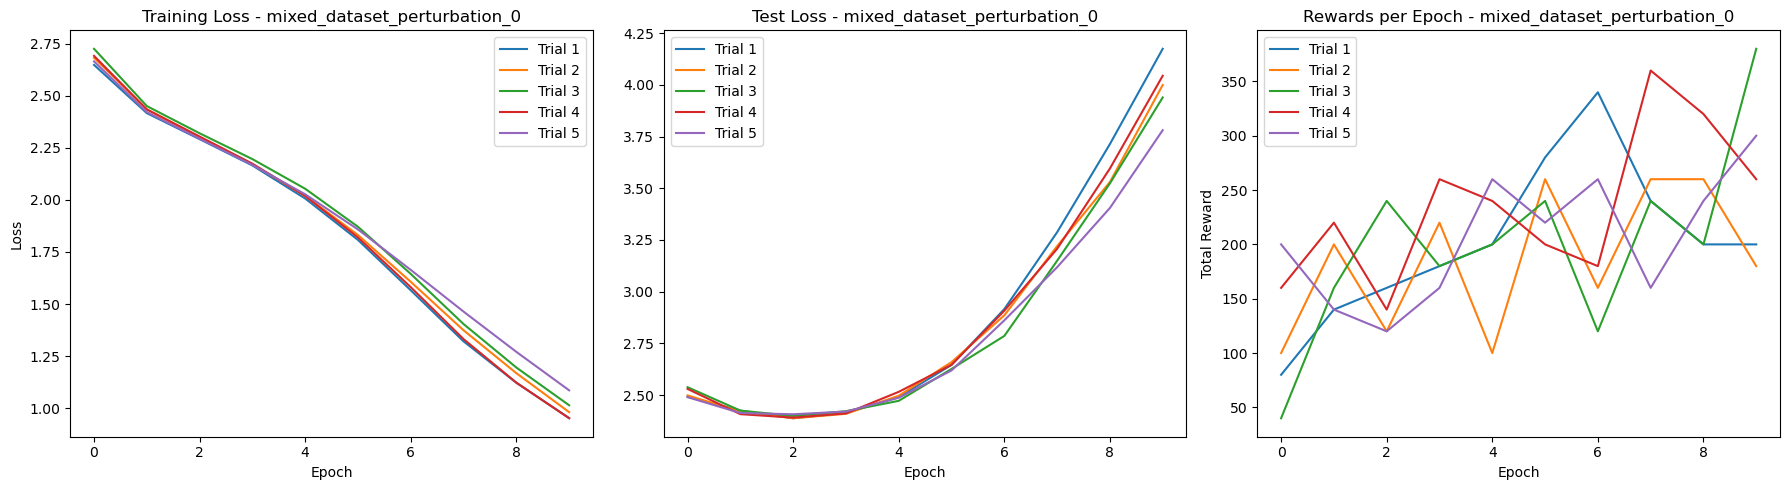

----- Execution time: Mixed Perturbation 0% -----
CPU times: total: 21min 40s
Wall time: 3h 55min 28s


In [11]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='mixed_dataset_perturbation_0',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Mixed Perturbation 0% -----")

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/mixed/mixed_logs/mixed_dataset_perturbation_5.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

print(dataloaders.keys())

Loading mixed_dataset_perturbation_5 dataset...
Data preprocessing for mixed_dataset_perturbation_5 dataset...
Creating dataloaders for mixed_dataset_perturbation_5 dataset...
dict_keys(['mixed_dataset_perturbation_5'])


In [8]:
# inspect dataset samples
dataset_name_to_inspect = 'mixed_dataset_perturbation_5'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting mixed_dataset_perturbation_5 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 8
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting mixed_dataset_perturbation_5 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: 

Training on mixed_dataset_perturbation_5
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [33:12<00:00, 199.22s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_5 - Training Loss: 1.03429
Finished Tuning on mixed_dataset_perturbation_5 - Tuning Loss: 4.13298
Finished Testing on mixed_dataset_perturbation_5 - Test Loss: 4.21572
Finished Evaluating on mixed_dataset_perturbation_5 - average Reward: 176.00
Loss curves saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_5/loss_curves_5.pkl
Model saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_5/bc_model_5.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [33:24<00:00, 200.47s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_5 - Training Loss: 1.09117
Finished Tuning on mixed_dataset_perturbation_5 - Tuning Loss: 3.94748
Finished Testing on mixed_dataset_perturbation_5 - Test Loss: 4.02346
Finished Evaluating on mixed_dataset_perturbation_5 - average Reward: 140.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [45:43<00:00, 274.31s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 8: 0.000900
Finished Training on mixed_dataset_perturbation_5 - Training Loss: 1.02406
Finished Tuning on mixed_dataset_perturbation_5 - Tuning Loss: 4.12892
Finished Testing on mixed_dataset_perturbation_5 - Test Loss: 4.18469
Finished Evaluating on mixed_dataset_perturbation_5 - average Reward: 202.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [46:35<00:00, 279.53s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_5 - Training Loss: 1.06855
Finished Tuning on mixed_dataset_perturbation_5 - Tuning Loss: 3.96568
Finished Testing on mixed_dataset_perturbation_5 - Test Loss: 4.01383
Finished Evaluating on mixed_dataset_perturbation_5 - average Reward: 204.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [49:59<00:00, 299.99s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_5 - Training Loss: 1.07763
Finished Tuning on mixed_dataset_perturbation_5 - Tuning Loss: 4.07575
Finished Testing on mixed_dataset_perturbation_5 - Test Loss: 4.08776
Finished Evaluating on mixed_dataset_perturbation_5 - average Reward: 220.00



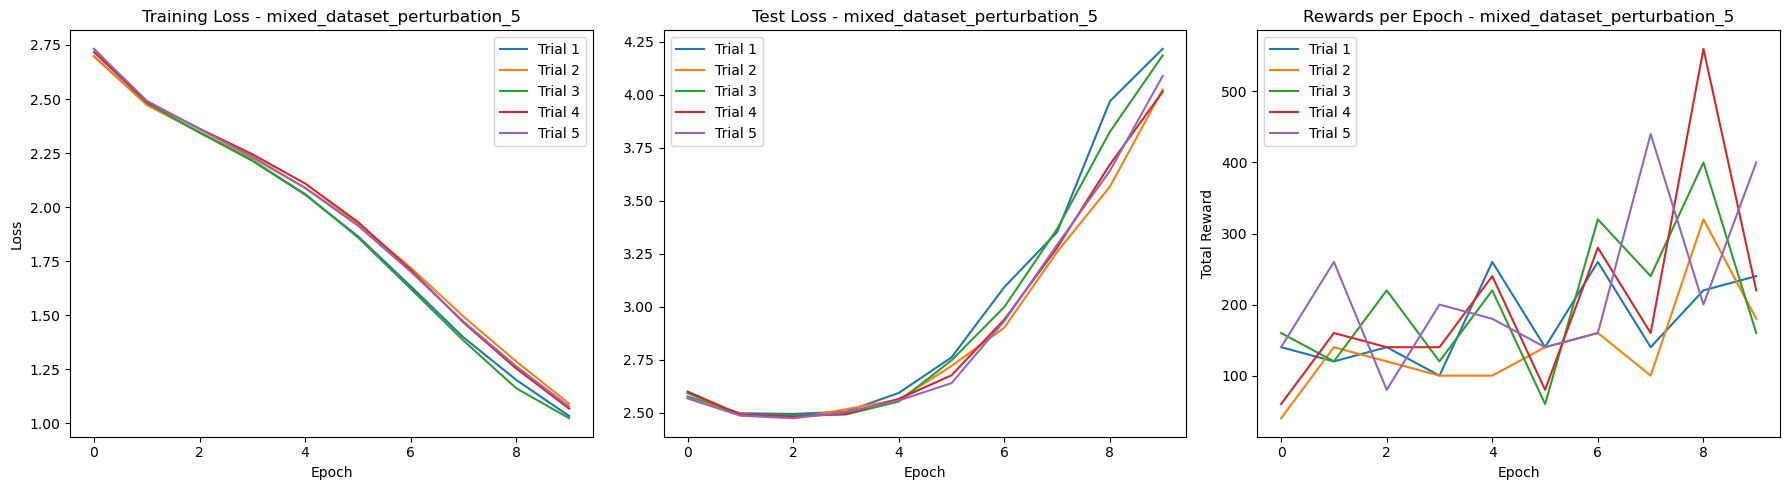

----- Execution time: Mixed Perturbation 5% -----
CPU times: total: 16min 48s
Wall time: 3h 28min 59s


In [9]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='mixed_dataset_perturbation_5',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Mixed Perturbation 5% -----")

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/mixed/mixed_logs/mixed_dataset_perturbation_10.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

print(dataloaders.keys())

Loading mixed_dataset_perturbation_10 dataset...
Data preprocessing for mixed_dataset_perturbation_10 dataset...
Creating dataloaders for mixed_dataset_perturbation_10 dataset...
dict_keys(['mixed_dataset_perturbation_10'])


In [8]:
# inspect dataset samples
dataset_name_to_inspect = 'mixed_dataset_perturbation_10'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting mixed_dataset_perturbation_10 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 15
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting mixed_dataset_perturbation_10 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Typ

Training on mixed_dataset_perturbation_10
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [42:13<00:00, 253.35s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_10 - Training Loss: 0.94358
Finished Tuning on mixed_dataset_perturbation_10 - Tuning Loss: 4.38234
Finished Testing on mixed_dataset_perturbation_10 - Test Loss: 4.42060
Finished Evaluating on mixed_dataset_perturbation_10 - average Reward: 244.00
Loss curves saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_10/loss_curves_10.pkl
Model saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_10/bc_model_10.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [49:49<00:00, 298.96s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_10 - Training Loss: 1.03814
Finished Tuning on mixed_dataset_perturbation_10 - Tuning Loss: 4.23535
Finished Testing on mixed_dataset_perturbation_10 - Test Loss: 4.23986
Finished Evaluating on mixed_dataset_perturbation_10 - average Reward: 186.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [2:18:46<00:00, 832.64s/it] 


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_10 - Training Loss: 1.03278
Finished Tuning on mixed_dataset_perturbation_10 - Tuning Loss: 4.17922
Finished Testing on mixed_dataset_perturbation_10 - Test Loss: 4.23091
Finished Evaluating on mixed_dataset_perturbation_10 - average Reward: 222.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [2:16:33<00:00, 819.37s/it]  


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_10 - Training Loss: 1.05802
Finished Tuning on mixed_dataset_perturbation_10 - Tuning Loss: 4.06123
Finished Testing on mixed_dataset_perturbation_10 - Test Loss: 4.11904
Finished Evaluating on mixed_dataset_perturbation_10 - average Reward: 274.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [55:42<00:00, 334.22s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_10 - Training Loss: 1.15300
Finished Tuning on mixed_dataset_perturbation_10 - Tuning Loss: 4.07098
Finished Testing on mixed_dataset_perturbation_10 - Test Loss: 4.12193
Finished Evaluating on mixed_dataset_perturbation_10 - average Reward: 188.00



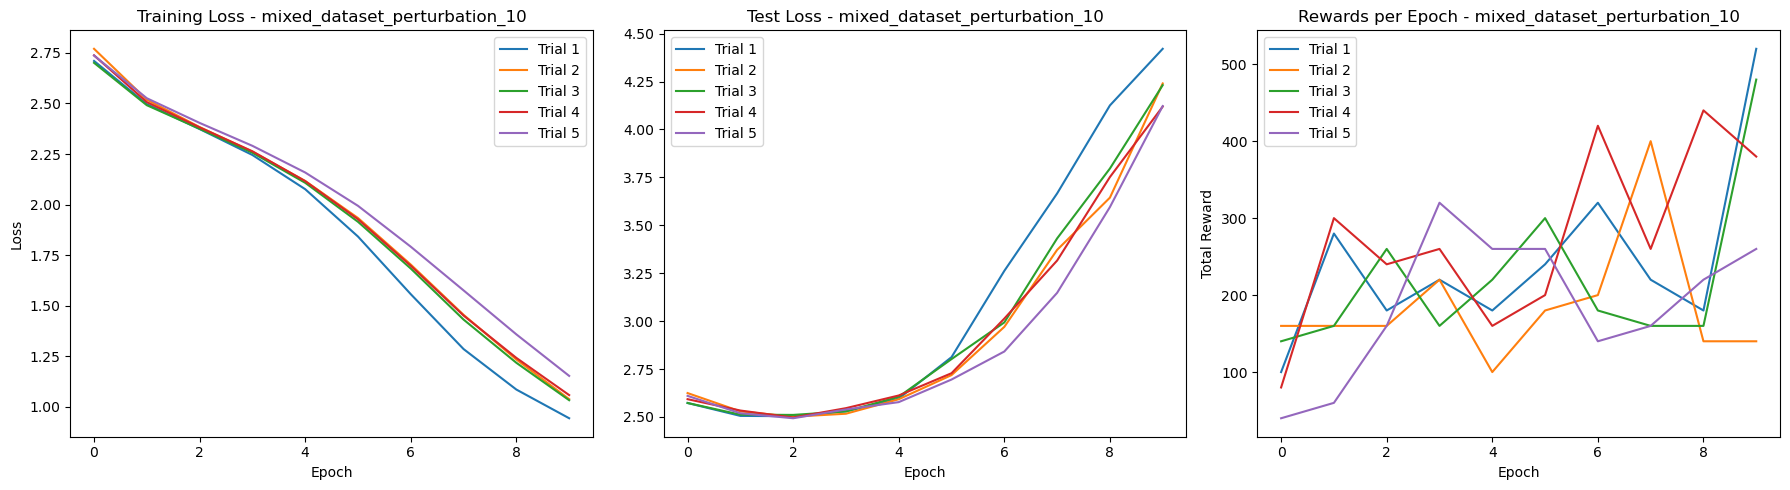

----- Execution time: Mixed Perturbation 10% -----
CPU times: total: 1h 33s
Wall time: 7h 3min 22s


: 

In [9]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='mixed_dataset_perturbation_10',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Mixed Perturbation 10% -----")

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/mixed/mixed_logs/mixed_dataset_perturbation_20.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

print(dataloaders.keys())

Loading mixed_dataset_perturbation_20 dataset...
Data preprocessing for mixed_dataset_perturbation_20 dataset...
Creating dataloaders for mixed_dataset_perturbation_20 dataset...
dict_keys(['mixed_dataset_perturbation_20'])


In [8]:
# inspect dataset samples
dataset_name_to_inspect = 'mixed_dataset_perturbation_20'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting mixed_dataset_perturbation_20 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 14
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting mixed_dataset_perturbation_20 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Typ

Training on mixed_dataset_perturbation_20
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [43:07<00:00, 258.75s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_20 - Training Loss: 1.18715
Finished Tuning on mixed_dataset_perturbation_20 - Tuning Loss: 4.19071
Finished Testing on mixed_dataset_perturbation_20 - Test Loss: 4.15318
Finished Evaluating on mixed_dataset_perturbation_20 - average Reward: 188.00
Loss curves saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_20/loss_curves_20.pkl
Model saved to behavioral_cloning_bc/bc_logs/mixed_dataset/perturbation_20/bc_model_20.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [45:28<00:00, 272.88s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_20 - Training Loss: 1.41431
Finished Tuning on mixed_dataset_perturbation_20 - Tuning Loss: 3.82027
Finished Testing on mixed_dataset_perturbation_20 - Test Loss: 3.83419
Finished Evaluating on mixed_dataset_perturbation_20 - average Reward: 228.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [51:40<00:00, 310.09s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_20 - Training Loss: 1.07669
Finished Tuning on mixed_dataset_perturbation_20 - Tuning Loss: 4.41645
Finished Testing on mixed_dataset_perturbation_20 - Test Loss: 4.40514
Finished Evaluating on mixed_dataset_perturbation_20 - average Reward: 258.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [48:31<00:00, 291.11s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_20 - Training Loss: 1.05804
Finished Tuning on mixed_dataset_perturbation_20 - Tuning Loss: 4.57568
Finished Testing on mixed_dataset_perturbation_20 - Test Loss: 4.54682
Finished Evaluating on mixed_dataset_perturbation_20 - average Reward: 190.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [58:39<00:00, 351.91s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on mixed_dataset_perturbation_20 - Training Loss: 1.17326
Finished Tuning on mixed_dataset_perturbation_20 - Tuning Loss: 4.35895
Finished Testing on mixed_dataset_perturbation_20 - Test Loss: 4.30153
Finished Evaluating on mixed_dataset_perturbation_20 - average Reward: 214.00



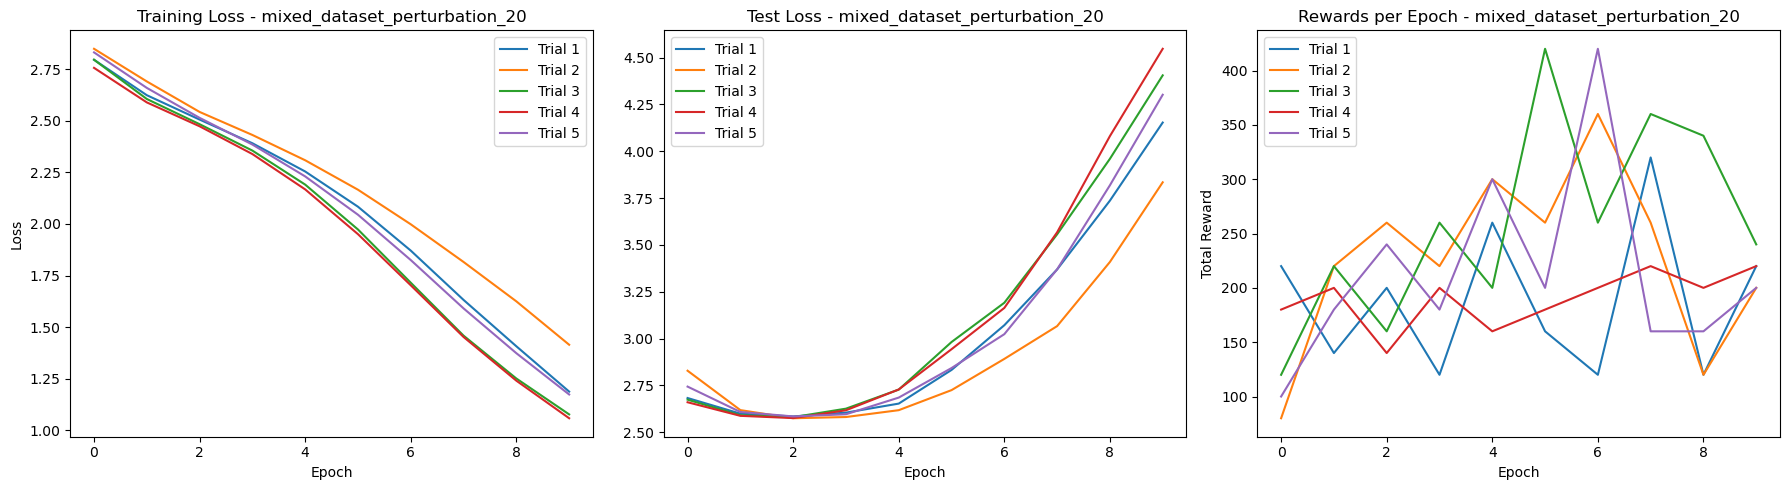

----- Execution time: Mixed Perturbation 20% -----
CPU times: total: 22min 58s
Wall time: 4h 7min 32s


In [9]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='mixed_dataset_perturbation_20',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Mixed Perturbation 20% -----")

# Replay

## Load datasets and Preprocess them

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/replay/replay_logs/replay_dataset_perturbation_0.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

print(dataloaders.keys())

Loading replay_dataset_perturbation_0 dataset...
Data preprocessing for replay_dataset_perturbation_0 dataset...
Creating dataloaders for replay_dataset_perturbation_0 dataset...
dict_keys(['replay_dataset_perturbation_0'])


In [8]:
# inspect dataset samples
dataset_name_to_inspect = 'replay_dataset_perturbation_0'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting replay_dataset_perturbation_0 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 9
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting replay_dataset_perturbation_0 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type

Training on replay_dataset_perturbation_0
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [41:33<00:00, 249.36s/it]


Initial learning rate: 0.001000
Finished Training on replay_dataset_perturbation_0 - Training Loss: 0.05054
Finished Tuning on replay_dataset_perturbation_0 - Tuning Loss: 0.05435
Finished Testing on replay_dataset_perturbation_0 - Test Loss: 0.05906
Finished Evaluating on replay_dataset_perturbation_0 - average Reward: 194.00
Loss curves saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_0/loss_curves_0.pkl
Model saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_0/bc_model_0.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [48:30<00:00, 291.01s/it]


Initial learning rate: 0.001000
Finished Training on replay_dataset_perturbation_0 - Training Loss: 0.06198
Finished Tuning on replay_dataset_perturbation_0 - Tuning Loss: 0.05568
Finished Testing on replay_dataset_perturbation_0 - Test Loss: 0.05742
Finished Evaluating on replay_dataset_perturbation_0 - average Reward: 210.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [1:03:04<00:00, 378.42s/it]


Initial learning rate: 0.001000
Finished Training on replay_dataset_perturbation_0 - Training Loss: 0.05676
Finished Tuning on replay_dataset_perturbation_0 - Tuning Loss: 0.05609
Finished Testing on replay_dataset_perturbation_0 - Test Loss: 0.06209
Finished Evaluating on replay_dataset_perturbation_0 - average Reward: 242.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [1:05:23<00:00, 392.34s/it]


Initial learning rate: 0.001000
Finished Training on replay_dataset_perturbation_0 - Training Loss: 0.05932
Finished Tuning on replay_dataset_perturbation_0 - Tuning Loss: 0.04853
Finished Testing on replay_dataset_perturbation_0 - Test Loss: 0.06172
Finished Evaluating on replay_dataset_perturbation_0 - average Reward: 284.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [59:43<00:00, 358.40s/it]


Initial learning rate: 0.001000
Finished Training on replay_dataset_perturbation_0 - Training Loss: 0.04944
Finished Tuning on replay_dataset_perturbation_0 - Tuning Loss: 0.04068
Finished Testing on replay_dataset_perturbation_0 - Test Loss: 0.04323
Finished Evaluating on replay_dataset_perturbation_0 - average Reward: 212.00



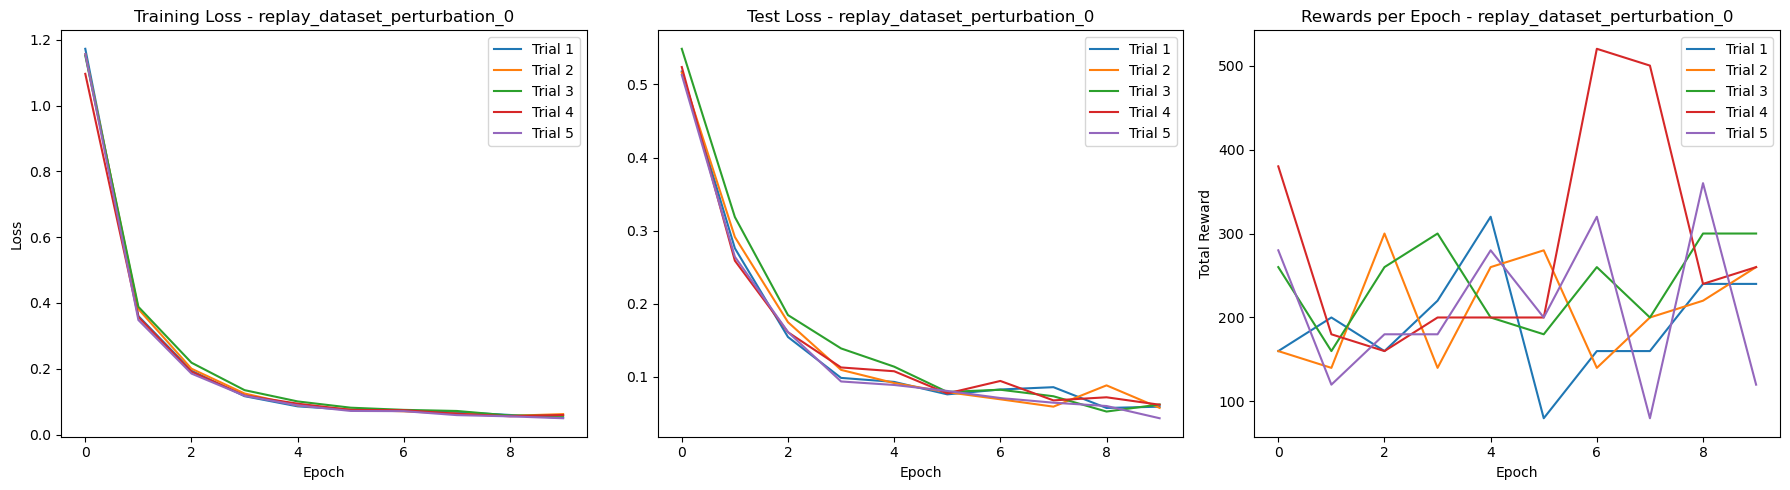

----- Execution time: Replay Perturbation 0% -----
CPU times: total: 27min 43s
Wall time: 4h 38min 21s


In [9]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='replay_dataset_perturbation_0',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Replay Perturbation 0% -----")

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/replay/replay_logs/replay_dataset_perturbation_5.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

print(dataloaders.keys())

Loading replay_dataset_perturbation_5 dataset...
Data preprocessing for replay_dataset_perturbation_5 dataset...
Creating dataloaders for replay_dataset_perturbation_5 dataset...
dict_keys(['replay_dataset_perturbation_5'])


In [8]:
# inspect dataset samples
dataset_name_to_inspect = 'replay_dataset_perturbation_5'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting replay_dataset_perturbation_5 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 6
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting replay_dataset_perturbation_5 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type

Training on replay_dataset_perturbation_5
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [45:06<00:00, 270.60s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_5 - Training Loss: 0.23810
Finished Tuning on replay_dataset_perturbation_5 - Tuning Loss: 1.90905
Finished Testing on replay_dataset_perturbation_5 - Test Loss: 2.00100
Finished Evaluating on replay_dataset_perturbation_5 - average Reward: 326.00
Loss curves saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_5/loss_curves_5.pkl
Model saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_5/bc_model_5.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [41:01<00:00, 246.19s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_5 - Training Loss: 0.24473
Finished Tuning on replay_dataset_perturbation_5 - Tuning Loss: 1.70749
Finished Testing on replay_dataset_perturbation_5 - Test Loss: 1.76485
Finished Evaluating on replay_dataset_perturbation_5 - average Reward: 228.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [51:14<00:00, 307.43s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on replay_dataset_perturbation_5 - Training Loss: 0.24219
Finished Tuning on replay_dataset_perturbation_5 - Tuning Loss: 1.87632
Finished Testing on replay_dataset_perturbation_5 - Test Loss: 1.93994
Finished Evaluating on replay_dataset_perturbation_5 - average Reward: 274.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [50:53<00:00, 305.31s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on replay_dataset_perturbation_5 - Training Loss: 0.28730
Finished Tuning on replay_dataset_perturbation_5 - Tuning Loss: 1.69808
Finished Testing on replay_dataset_perturbation_5 - Test Loss: 1.78297
Finished Evaluating on replay_dataset_perturbation_5 - average Reward: 198.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [52:14<00:00, 313.40s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on replay_dataset_perturbation_5 - Training Loss: 0.23506
Finished Tuning on replay_dataset_perturbation_5 - Tuning Loss: 1.85561
Finished Testing on replay_dataset_perturbation_5 - Test Loss: 1.91575
Finished Evaluating on replay_dataset_perturbation_5 - average Reward: 230.00



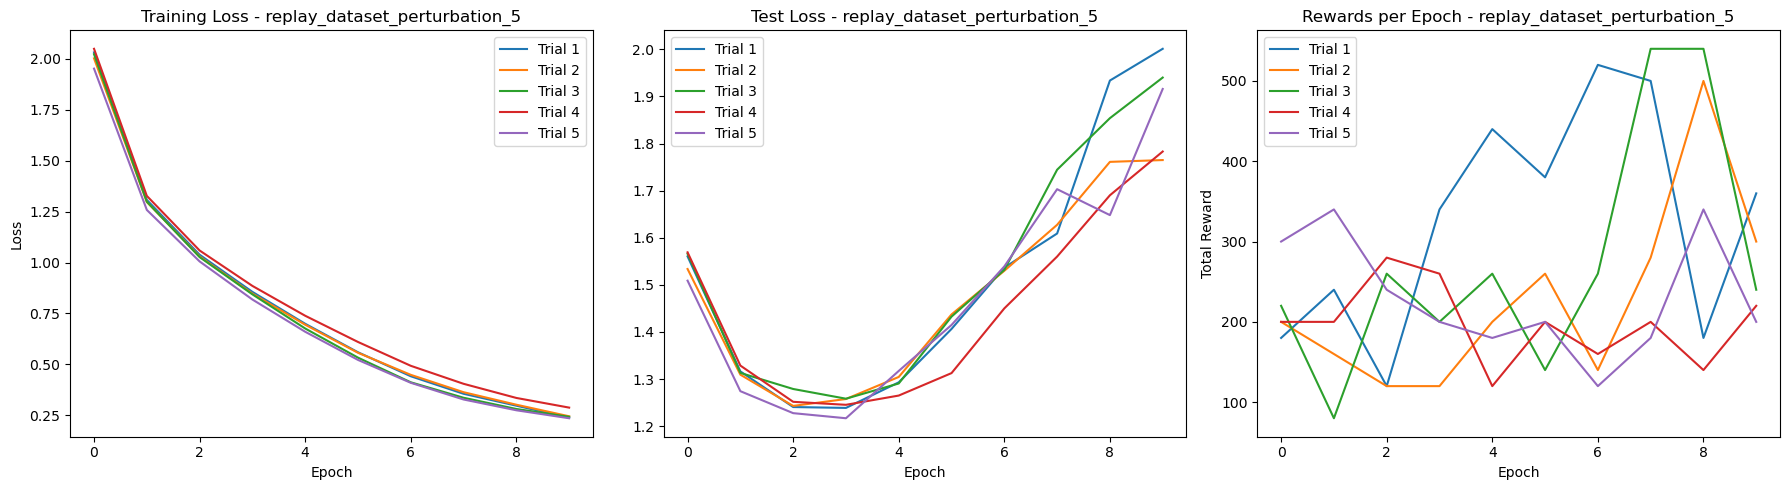

----- Execution time: Replay Perturbation 5% -----
CPU times: total: 20min 38s
Wall time: 4h 34s


: 

In [9]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='replay_dataset_perturbation_5',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Replay Perturbation 5% -----")

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/replay/replay_logs/replay_dataset_perturbation_10.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

print(dataloaders.keys())

Loading replay_dataset_perturbation_10 dataset...
Data preprocessing for replay_dataset_perturbation_10 dataset...
Creating dataloaders for replay_dataset_perturbation_10 dataset...
dict_keys(['replay_dataset_perturbation_10'])


In [8]:
# inspect dataset samples
dataset_name_to_inspect = 'replay_dataset_perturbation_10'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting replay_dataset_perturbation_10 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 12
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting replay_dataset_perturbation_10 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data T

Training on replay_dataset_perturbation_10
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [47:20<00:00, 284.08s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_10 - Training Loss: 0.30202
Finished Tuning on replay_dataset_perturbation_10 - Tuning Loss: 2.26792
Finished Testing on replay_dataset_perturbation_10 - Test Loss: 2.28495
Finished Evaluating on replay_dataset_perturbation_10 - average Reward: 302.00
Loss curves saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_10/loss_curves_10.pkl
Model saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_10/bc_model_10.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [46:27<00:00, 278.78s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on replay_dataset_perturbation_10 - Training Loss: 0.30714
Finished Tuning on replay_dataset_perturbation_10 - Tuning Loss: 2.25678
Finished Testing on replay_dataset_perturbation_10 - Test Loss: 2.26445
Finished Evaluating on replay_dataset_perturbation_10 - average Reward: 290.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [57:52<00:00, 347.23s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on replay_dataset_perturbation_10 - Training Loss: 0.33308
Finished Tuning on replay_dataset_perturbation_10 - Tuning Loss: 2.24434
Finished Testing on replay_dataset_perturbation_10 - Test Loss: 2.25671
Finished Evaluating on replay_dataset_perturbation_10 - average Reward: 278.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [57:07<00:00, 342.79s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 10: 0.000900
Finished Training on replay_dataset_perturbation_10 - Training Loss: 0.31716
Finished Tuning on replay_dataset_perturbation_10 - Tuning Loss: 2.18093
Finished Testing on replay_dataset_perturbation_10 - Test Loss: 2.18772
Finished Evaluating on replay_dataset_perturbation_10 - average Reward: 234.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [1:04:15<00:00, 385.59s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_10 - Training Loss: 0.29403
Finished Tuning on replay_dataset_perturbation_10 - Tuning Loss: 2.30701
Finished Testing on replay_dataset_perturbation_10 - Test Loss: 2.31884
Finished Evaluating on replay_dataset_perturbation_10 - average Reward: 332.00



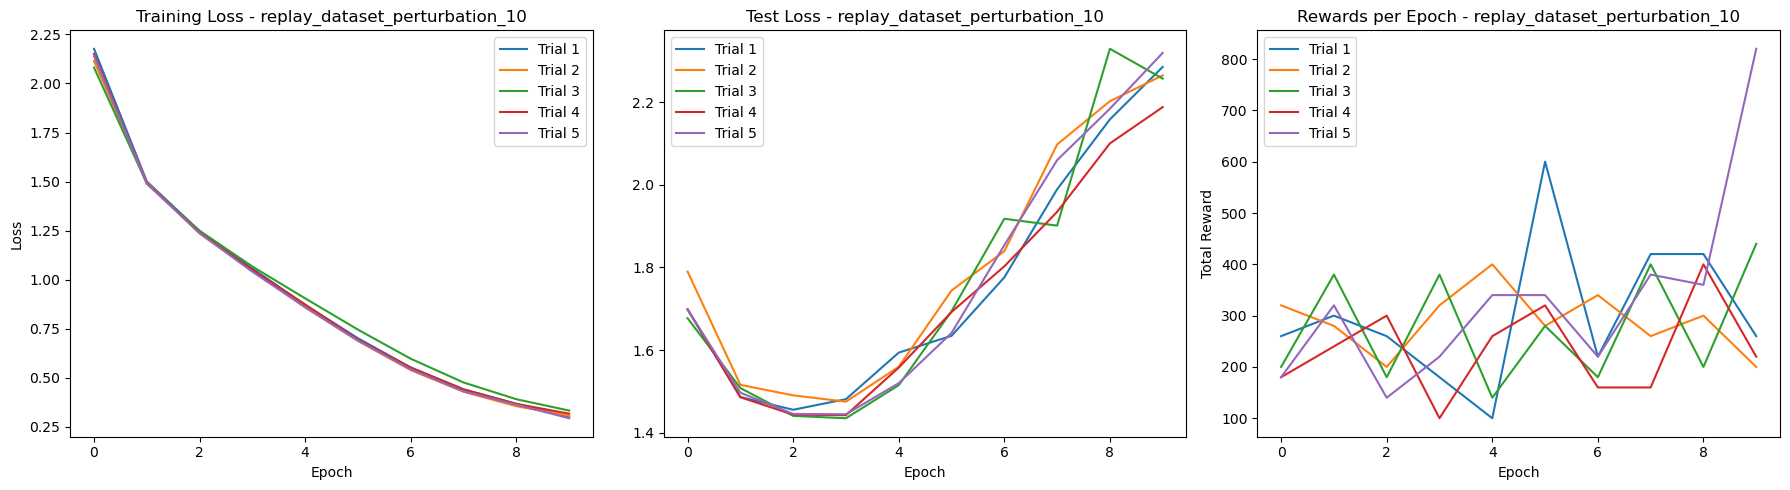

----- Execution time: Replay Perturbation 10% -----
CPU times: total: 25min 40s
Wall time: 4h 33min 12s


In [9]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='replay_dataset_perturbation_10',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Replay Perturbation 10% -----")

In [7]:
# Paths to your datasets
dataset_paths = [
    'datasets/replay/replay_logs/replay_dataset_perturbation_20.pkl',
]

dataloaders = {}  # Store dataloaders for each dataset

for path in dataset_paths:
    dataset_name = path.split('/')[-1].split('.')[0]  # Extract dataset name

    print(f"Loading {dataset_name} dataset...")

    # Load dataset
    data = load_dataset(path)

    print(f"Data preprocessing for {dataset_name} dataset...")

    # Preprocess and split the data
    train_data, test_data, tune_data = preprocess_and_split(
        data=data, seed=SEED, test_size=0.2, tune_size=0.1
    )

    print(f"Creating dataloaders for {dataset_name} dataset...")

    # Create dataloaders using the adjusted function
    train_loader, test_loader, tune_loader = create_dataloaders(
        train_data, test_data, tune_data, batch_size=64, seed=SEED
    )

    # Store dataloaders
    dataloaders[dataset_name] = {
        'train': train_loader,
        'test': test_loader,
        'tuning': tune_loader
    }

    # Clear variables to free up memory
    del data, train_data, test_data, tune_data
    gc.collect()

print(dataloaders.keys())

Loading replay_dataset_perturbation_20 dataset...
Data preprocessing for replay_dataset_perturbation_20 dataset...
Creating dataloaders for replay_dataset_perturbation_20 dataset...
dict_keys(['replay_dataset_perturbation_20'])


In [8]:
# inspect dataset samples
dataset_name_to_inspect = 'replay_dataset_perturbation_20'

# inspect the training set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Training Set:")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['train'])
print("\n")

# inspect the testing set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Testing Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['test'])
print("\n")

# inspect the tuning set of the dataset
print(f"Inspecting {dataset_name_to_inspect} Tuning Set")
inspect_dataset_sample(dataloaders[dataset_name_to_inspect]['tuning'])

Inspecting replay_dataset_perturbation_20 Training Set:
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Type: torch.float32
Actions Batch Data Type: torch.int64
Rewards Batch Data Type: torch.float32
Next States Batch Data Type: torch.float32
Dones Batch Data Type: torch.float32

First Sample Details:
First State Shape: torch.Size([3, 210, 160])
First State Min/Max: 0.0000/0.8392
First Action: 4
First Reward: 0.0000
First Next State Shape: torch.Size([3, 210, 160])
First Done: 0.0


Inspecting replay_dataset_perturbation_20 Testing Set
--- Sample 1 ---
States Batch Shape: torch.Size([64, 3, 210, 160])
Actions Batch Shape: torch.Size([64])
Rewards Batch Shape: torch.Size([64])
Next States Batch Shape: torch.Size([64, 3, 210, 160])
Dones Batch Shape: torch.Size([64])
States Batch Data Ty

Training on replay_dataset_perturbation_20
-- Starting Trial 1/5 --


Epochs: 100%|██████████| 10/10 [43:07<00:00, 258.79s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_20 - Training Loss: 0.43660
Finished Tuning on replay_dataset_perturbation_20 - Tuning Loss: 3.07931
Finished Testing on replay_dataset_perturbation_20 - Test Loss: 3.11955
Finished Evaluating on replay_dataset_perturbation_20 - average Reward: 188.00
Loss curves saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_20/loss_curves_20.pkl
Model saved to behavioral_cloning_bc/bc_logs/replay_dataset/perturbation_20/bc_model_20.pth
-- Starting Trial 2/5 --


Epochs: 100%|██████████| 10/10 [44:49<00:00, 268.95s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_20 - Training Loss: 0.45055
Finished Tuning on replay_dataset_perturbation_20 - Tuning Loss: 2.94612
Finished Testing on replay_dataset_perturbation_20 - Test Loss: 2.86801
Finished Evaluating on replay_dataset_perturbation_20 - average Reward: 202.00
-- Starting Trial 3/5 --


Epochs: 100%|██████████| 10/10 [1:00:25<00:00, 362.56s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_20 - Training Loss: 0.42593
Finished Tuning on replay_dataset_perturbation_20 - Tuning Loss: 3.14764
Finished Testing on replay_dataset_perturbation_20 - Test Loss: 3.13358
Finished Evaluating on replay_dataset_perturbation_20 - average Reward: 268.00
-- Starting Trial 4/5 --


Epochs: 100%|██████████| 10/10 [51:59<00:00, 311.91s/it]


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_20 - Training Loss: 0.44935
Finished Tuning on replay_dataset_perturbation_20 - Tuning Loss: 3.14120
Finished Testing on replay_dataset_perturbation_20 - Test Loss: 3.12202
Finished Evaluating on replay_dataset_perturbation_20 - average Reward: 194.00
-- Starting Trial 5/5 --


Epochs: 100%|██████████| 10/10 [2:08:47<00:00, 772.70s/it]  


Initial learning rate: 0.001000
Adjusted learning rate in epoch 9: 0.000900
Finished Training on replay_dataset_perturbation_20 - Training Loss: 0.45752
Finished Tuning on replay_dataset_perturbation_20 - Tuning Loss: 2.90891
Finished Testing on replay_dataset_perturbation_20 - Test Loss: 2.86710
Finished Evaluating on replay_dataset_perturbation_20 - average Reward: 224.00



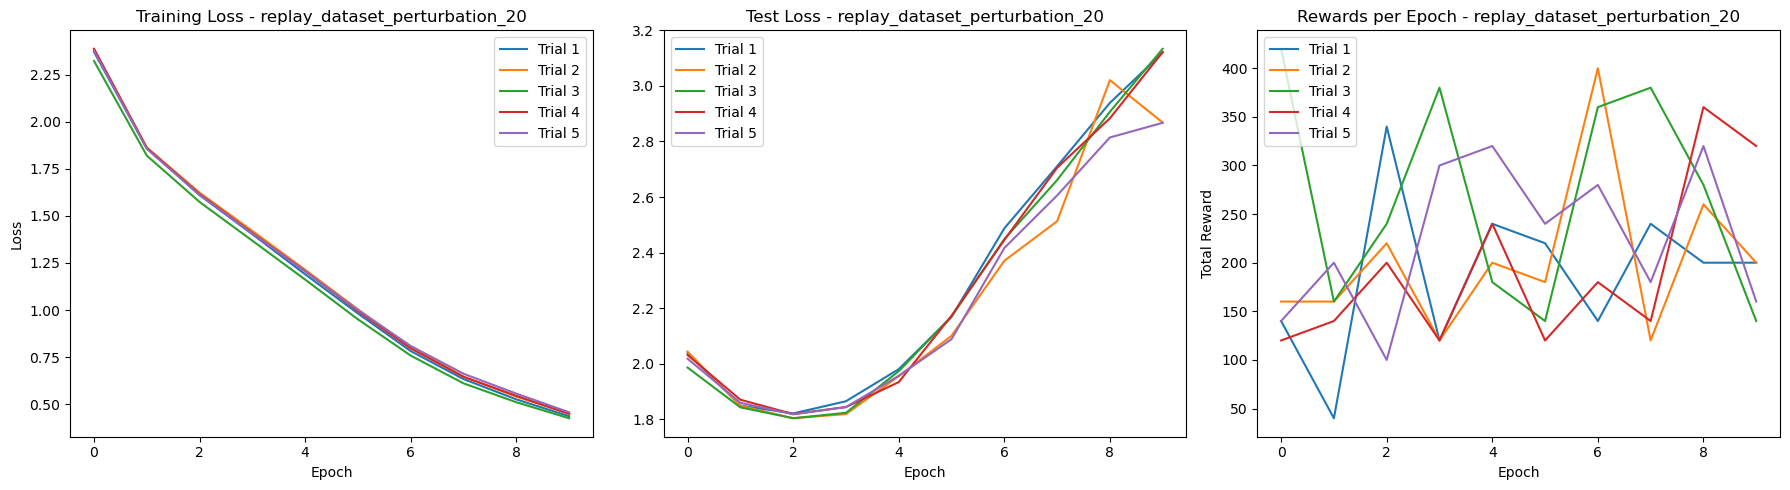

----- Execution time: Replay Perturbation 20% -----
CPU times: total: 1h 10min 5s
Wall time: 5h 29min 13s


In [9]:
%%time

# train and evaluate the BC model on the Random dataset
train_and_evaluate_BC(
    dataloaders=dataloaders,
    device=device,
    trials=TRIALS,
    epochs=EPOCHS,
    dataset='replay_dataset_perturbation_20',
    env_id=ENV_ID,
    seed=SEED
)

# print execution time it took to train the model
print("----- Execution time: Replay Perturbation 20% -----")